# DeepAR Model for Forecasting Bitcoin Transaction Fees (Next 24 Hours)

This notebook builds and evaluates a DeepAR model to forecast the **Bitcoin transaction fee** over the **next 24 hours** , using **15-minute interval data** resampled from the raw mempool dataset.

## Why We Chose DeepAR for Bitcoin Fee Forecasting?

Our exploratory data analysis revealed several key characteristics in the Bitcoin fee time series that informed our model selection:

### Key Observations from EDA

- **Strong temporal patterns**: The series exhibits clear intraday and multi-day cycles.
- **Volatility and sharp spikes**: Transaction fees fluctuate unpredictably with sudden, high-magnitude surges.
- **Multivariate dependencies**: Fee behavior is influenced by multiple covariates such as mempool congestion, difficulty adjustment, and market signals.
- **Lagged effects**: Both the target and covariates show meaningful dependencies on past values.

### Why DeepAR is a Good Fit

- **Probabilistic autoregressive modeling**: DeepAR models future values as a distribution conditioned on historical data, making it suitable for capturing uncertainty and variability.
- **Sequence-to-sequence RNN structure**: It naturally captures temporal dependencies and lagged effects, especially for high-frequency financial time series.
- **Handles multiple related time series**: DeepAR can leverage patterns across different fee types (e.g., fastestFee, hourFee, economyFee) to improve prediction accuracy.
- **Distributional output**: The model supports flexible likelihoods (e.g., Gaussian, LogNormal), making it adaptable to the right-skewed nature of fee data.
- **Scalable and generalizable**: Suitable for long training histories and aligned prediction horizons across series.

Given these factors, DeepAR offers a strong balance of flexibility, probabilistic forecasting, and temporal modeling capacity for our transaction fee prediction task.
> **Code Location**: See `scripts/advanced_deepar.py` for the main model implementation and training pipeline.

## 1. Data Import, Transformation, and Preparation

This section prepares the dataset for training a DeepAR model:

1. **Preprocessing**: Convert the raw time series into a long-format structure with consistent time intervals for each `series_id`.

2. **Transformation**: Encode time-related features (e.g., hour of day, day of week) and handle any missing timestamps to ensure temporal consistency.

3. **Scaling**: Normalize the target variable and relevant covariates to stabilize training and improve model convergence.

These steps ensure the model receives structured, normalized, and correctly segmented input data suitable for probabilistic forecasting.


In [24]:
import lightning.pytorch as pl

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from pytorch_forecasting import DeepAR

import sys
from pathlib import Path

# Add ../src to the Python module search path
src_path = Path("..") / "src"
sys.path.append(str(src_path.resolve()))
from split_series import split_series
from scale_series import scale_series
from preprocess_raw_parquet import preprocess_raw_parquet
from transform_fee_data_dl import transform_fee_data_dl
from compute_metrics_per_series import compute_metrics
from plot_series import plot_series

In [12]:
FREQ = "15min"  # Frequency of the time series: one data point every 15 minutes.
ENC_LEN = 672  # Length of the encoder input (7 days): 672 × 15min = 7 days.
PRED_STEPS = 96  # Forecasting horizon (1 day): 96 × 15min = 24 hours.

BATCH_SIZE = 128  # Number of samples per batch for model training.
NUM_WORKERS = 4  # Number of CPU threads used for data loading.


In [13]:
# Import raw Bitcoin mempool and fee data, clean, and resample it
df = preprocess_raw_parquet("../data/raw/mar_5_may_12.parquet")  # Clean and structure raw input from .parquet
df = df.iloc[:-PRED_STEPS]
df.head()

,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,recommended_fee_fastestFee,recommended_fee_halfHourFee,recommended_fee_hourFee,recommended_fee_economyFee,recommended_fee_minimumFee,...,mempool_fee_histogram_bin_70_75,mempool_fee_histogram_bin_75_80,mempool_fee_histogram_bin_80_85,mempool_fee_histogram_bin_85_90,mempool_fee_histogram_bin_90_95,mempool_fee_histogram_bin_95_100,mempool_fee_histogram_bin_100_150,mempool_fee_histogram_bin_150_200,mempool_fee_histogram_bin_200_250,mempool_fee_histogram_bin_250_300
timestamp,,,,,,,,,,,,,,,,,,,,,
2025-03-05 02:00:00,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:15:00,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,3.000000,2.666667,2.666667,2.666667,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:30:00,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,2.000000,2.000000,2.000000,2.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 02:45:00,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,2.333333,2.333333,2.333333,2.333333,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2025-03-05 03:00:00,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,3.333333,3.000000,3.000000,3.000000,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [14]:
# Transform the cleaned data for DeepAR modeling
df = transform_fee_data_dl(df)  # Adds time encodings, reshapes to long format, assigns time_idx

df.head()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
0,2025-03-05 02:00:00,recommended_fee_economyFee,2.000000,2.170952e+06,997895.375000,793.000000,1.846754e+06,1.300111,7971.000000,4.809659e+07,...,0.0,0,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00
1,2025-03-05 02:15:00,recommended_fee_economyFee,2.666667,1.801526e+06,997925.916667,2627.000000,3.407913e+06,2.473960,9943.333333,4.946978e+07,...,0.0,1,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,1.000000e+00,2.832769e-16
2,2025-03-05 02:30:00,recommended_fee_economyFee,2.000000,2.055350e+06,997965.916667,922.000000,1.855358e+06,1.355898,8189.333333,4.936482e+07,...,0.0,2,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,5.665539e-16,-1.000000e+00
3,2025-03-05 02:45:00,recommended_fee_economyFee,2.333333,2.006800e+06,997970.083333,1296.666667,2.167251e+06,1.536092,8874.666667,5.061585e+07,...,0.0,3,0.500000,0.866025,0.974928,-0.222521,1.0,6.123234e-17,-1.000000e+00,-1.836970e-16
4,2025-03-05 03:00:00,recommended_fee_economyFee,3.000000,1.773658e+06,997960.333333,2725.333333,3.462741e+06,2.467659,11247.333333,5.158261e+07,...,0.0,4,0.707107,0.707107,0.974928,-0.222521,1.0,6.123234e-17,0.000000e+00,1.000000e+00


In [15]:
# Split dataset into training and validation sets with the last PRED_STEPS for validation
df_train, df_valid = split_series(df, PRED_STEPS)

# Normalize both train and validation sets using statistics from training data
df_train, df_valid, scaler = scale_series(df_train, df_valid)


### Why This Step Is Cruical:  
- DeepAR assumes evenly spaced sequences and benefits from standardized inputs.  
- Proper splitting ensures that validation/test sets simulate real-world future forecasting.  
- Transformation aligns data with DeepAR's encoder-decoder format, enabling autoregressive learning.  
- Normalization improves training stability and convergence.

## 2. Create DeepAR-Compatible TimeSeriesDataSet
In this step, we construct `TimeSeriesDataSet` objects required by DeepAR:

1. **Define time indices and group IDs**: Specify `time_idx` to order observations and `series_id` to group individual time series.

2. **Specify covariates**:
   - *Static features* (e.g., category labels) that remain constant over time.
   - *Time-varying known/categorical features* (e.g., hour, day of week).
   - *Time-varying real features* (e.g., mempool size, fee signals).

3. **Normalize target**: Apply normalization to the target variable to stabilize training.

This setup enables correct slicing into encoder/decoder windows and supports autoregressive training with both static and dynamic inputs.
> This configuration logic is implemented in `scripts/deepar/deepar_create_dataloaders.py`.


### Why This Step Is Crucial:  
- DeepAR needs structured input with consistent history and forecast windows.  
- Group normalization stabilizes learning across heterogeneous series.  
- Using `from_dataset` ensures validation data is aligned identically with training preprocessing, avoiding leakage and inconsistency.  
- Encodes time context (sin/cos) to help the model capture periodic patterns like hourly/daily cycles.

## 3. Create DataLoaders for DeepAR Training and Validation
We now convert the `TimeSeriesDataSet` objects into PyTorch-compatible DataLoaders:

1. **Batching**: Wrap training and validation datasets into DataLoaders to enable efficient mini-batch processing.

2. **Ordering**: Disable shuffling to preserve the temporal order of time series data, which is critical for autoregressive models like DeepAR.

3. **Batch size tuning**: Use a standard batch size for training and a larger batch size for validation to accelerate evaluation.

This step prepares the data for GPU-accelerated training while ensuring proper temporal alignment.
> This dataloader construction logic is implemented in `scripts/deepar/deepar_create_dataloaders.py`.


### Why This Step Is Crucial:  
- Ensures efficient loading of sequence data into the DeepAR model for both training and evaluation.  
- Maintains time dependency by disabling shuffling — crucial for autoregressive models.  
- Larger validation batches reduce runtime since no gradients are computed.

## 4. Initialize DeepAR Model and Tune Learning Rate

In this section, we initialize the DeepAR model and tune its learning rate:

1. **Model Initialization**: Define the DeepAR architecture with key hyperparameters such as hidden size, dropout rate, and loss function.

2. **Trainer Setup**: Use PyTorch Lightning’s `Trainer` to manage training configuration, including callbacks, logging, and hardware acceleration.

3. **Learning Rate Tuning**: Run PyTorch Lightning’s `Tuner` to automatically find an optimal learning rate that improves convergence stability.

This setup ensures the model is both well-structured and optimally configured before training begins.
> This initialization and learning rate tuning logic is implemented in `scripts/deepar/deepar_train_model.py`.


### Why This Step Is Crucial:  
- Choosing the correct learning rate is critical to DeepAR’s convergence.  
- Learning rate tuning prevents instability (too high) or slow training (too low).  
- `MultivariateNormalDistributionLoss` supports probabilistic outputs, allowing the model to estimate uncertainty, which is useful for forecasting volatile transaction fees.

## 5. Train DeepAR Model with Early Stopping

This section configures and runs the DeepAR training process using PyTorch Lightning:

1. **Early Stopping**: Apply early stopping to monitor validation loss and halt training when performance no longer improves, reducing overfitting and saving compute time.

2. **Trainer Configuration**: Set up the PyTorch Lightning `Trainer` with parameters such as max epochs, callbacks, and GPU acceleration.

3. **Model Training**: Train the DeepAR model using the tuned configuration and previously prepared DataLoaders.

This process ensures efficient and robust model training with automatic performance monitoring.
> This model training and early stopping logic is implemented in `scripts/deepar/deepar_train_model.py`.



### Why This Step Is Crucial:  
- Training with early stopping helps avoid overfitting and wasted computation.  
- The chosen loss function allows DeepAR to model uncertainty, crucial for forecasting Bitcoin fees.  
- Proper training orchestration ensures reproducibility and model checkpointing for later evaluation.

## 6. Load Best Model, Generate Predictions, and Evaluate Forecasts

After training, we evaluate the DeepAR model's performance:

1. **Model Loading**: Load the best checkpointed DeepAR model based on the lowest validation loss.

2. **Prediction**: Run multi-sample forecasts on the test set to capture uncertainty and variability in predictions.

3. **Evaluation**: Compute evaluation metrics including:
   - **MAE** (Mean Absolute Error)
   - **RMSE** (Root Mean Squared Error)
   - **MAPE** (Mean Absolute Percentage Error)
   - **Custom Loss**: A composite metric combining MAE, standard deviation penalty, and deviation error to reflect both pointwise accuracy and forecast reliability.

This comprehensive evaluation highlights both the model’s predictive accuracy and its ability to reflect uncertainty.


In [16]:
# Path to the saved DeepAR model (full model saved with torch.save)
best_model_path = "../results/models/best_deepar_model_v5.ckpt"
# best_model_path = "../results/models/best-deepar-full.ckpt" # Or use the model you train
model = DeepAR.load_from_checkpoint(best_model_path, map_location="cpu")

# Set to eval mode
_ = model.eval()

/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [17]:
# Set seed and run raw prediction with 100 samples (for distributional output)
pl.seed_everything(42)
raw_predictions = model.predict(
    df_valid,
    mode="raw",
    return_x=True,
    n_samples=100,
    trainer_kwargs=dict(accelerator="cpu")
)

Seed set to 42
You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (mps), used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/setup.py:177: GPU available but not used. You can set it by doing `Trainer(accelerator='gpu')`.
/Users/liuyajing/miniforge3/envs/satcast/lib/python3.11/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


In [18]:
# Extract true values for final prediction window
df_true = df_valid[
    lambda x: (x.time_idx > x.time_idx.max() - PRED_STEPS) & (x.time_idx <= x.time_idx.max())
]
df_true.tail()

,timestamp,series_id,target,mempool_blocks_blockSize,mempool_blocks_blockVSize,mempool_blocks_nTx,mempool_blocks_totalFees,mempool_blocks_medianFee,mempool_count,mempool_vsize,...,mempool_fee_histogram_bin_250_300,time_idx,hour_sin,hour_cos,day_of_week_sin,day_of_week_cos,month_sin,month_cos,minute_sin,minute_cos
32515,2025-05-11 18:45:00,recommended_fee_minimumFee,1.0,-2.698177,-3.350181,-1.466282,-0.882059,-0.719122,-1.141006,-1.092308,...,0.0,6499,-1.000000,-1.836970e-16,-0.781831,0.62349,0.5,-0.866025,-1.000000e+00,-1.836970e-16
32516,2025-05-11 19:00:00,recommended_fee_minimumFee,1.0,-3.720925,-4.950532,-1.920068,-1.100689,-0.911363,-1.190222,-1.111072,...,0.0,6500,-0.965926,2.588190e-01,-0.781831,0.62349,0.5,-0.866025,0.000000e+00,1.000000e+00
32517,2025-05-11 19:15:00,recommended_fee_minimumFee,1.0,-0.389310,-0.245134,0.170356,-0.370534,-0.215084,-0.912175,-1.040731,...,0.0,6501,-0.965926,2.588190e-01,-0.781831,0.62349,0.5,-0.866025,1.000000e+00,2.832769e-16
32518,2025-05-11 19:30:00,recommended_fee_minimumFee,1.0,-0.021092,0.316194,0.879805,0.411153,0.097310,-0.652602,-0.974523,...,0.0,6502,-0.965926,2.588190e-01,-0.781831,0.62349,0.5,-0.866025,5.665539e-16,-1.000000e+00
32519,2025-05-11 19:45:00,recommended_fee_minimumFee,1.0,-0.090955,0.316373,0.940942,0.396153,0.165572,-0.545078,-0.942984,...,0.0,6503,-0.965926,2.588190e-01,-0.781831,0.62349,0.5,-0.866025,-1.000000e+00,-1.836970e-16


In [19]:
# Post-process prediction tensor → median forecast
pred_np = (
    raw_predictions.output.prediction.detach().cpu().numpy()
)  # Shape: (samples, series, time)
y_pred = np.median(pred_np, axis=-1).flatten()  # Median across samples
time_idx = raw_predictions.x["decoder_time_idx"].detach().cpu().numpy().flatten()

# Merge predictions with metadata and ground truth
df_eval = pd.DataFrame(
    dict(
        timestamp=df_true["timestamp"],
        time_idx=time_idx,
        series_id=df_true["series_id"],
        y_true=df_true["target"],
        y_pred=y_pred,
    )
)

df_eval.head()

,timestamp,time_idx,series_id,y_true,y_pred
6408,2025-05-10 20:00:00,6408,recommended_fee_economyFee,2.0,1.437433
6409,2025-05-10 20:15:00,6409,recommended_fee_economyFee,2.0,1.582983
6410,2025-05-10 20:30:00,6410,recommended_fee_economyFee,2.0,1.558577
6411,2025-05-10 20:45:00,6411,recommended_fee_economyFee,2.0,1.554276
6412,2025-05-10 21:00:00,6412,recommended_fee_economyFee,2.0,1.574377


In [22]:
compute_metrics(df_eval)

,series_id,MAE,RMSE,MAPE,Custom Loss (MAE+STD+Dev)
4,recommended_fee_minimumFee,0.000038,0.000046,0.000038,0.000096
0,recommended_fee_economyFee,0.460244,0.496847,0.373213,1.342578
3,recommended_fee_hourFee,0.781605,0.868438,0.572924,2.133691
2,recommended_fee_halfHourFee,0.770656,0.955447,0.529608,2.195611
1,recommended_fee_fastestFee,0.924080,1.152672,0.510507,2.547531


- **MAE** reflects average error in absolute terms.
- **RMSE** penalizes larger errors more heavily.
- **MAPE** is scale-independent and expresses error as a percentage.
- **Custom Loss (MAE + STD + Deviation Error)** is a composite objective function that combines:
  - **MAE**: Ensures accurate average predictions.
  - **STD**: Penalizes the mismatch in standard deviation between predictions and ground truth, encouraging the model to capture the true **volatility** of the target series.
  - **Deviation error**: Adds a penalty based on the shape difference between the predicted and actual curves, computed via deviation from the mean. This promotes forecasts that better mirror the **temporal dynamics** and **fluctuation patterns** of the real data.

This custom loss is especially effective in capturing not just the central trend but also the spread and structure of volatile Bitcoin fee sequences — making it suitable for multi-horizon forecasting in dynamic environments.


### Why This Step Is Crucial:  
- Ensures evaluation is based on the best-performing model checkpoint.  
- Median over samples provides robust point forecasts from probabilistic DeepAR output.  
- Custom metric with MAE + STD + devErr penalty balances accuracy with stability, rewarding consistent yet sharp forecasts — critical for volatile series like Bitcoin fees.

## 7. Visualize Forecasts: Actual vs. Predicted per Series
To qualitatively assess DeepAR’s performance, we visualize its forecasts:

1. **Prediction vs. Actual Plots**: Generate line plots comparing predicted and actual transaction fees for multiple `series_id` values.

2. **Spike Analysis**: Visually inspect whether the model captures key characteristics such as the **timing**, **magnitude**, and **shape** of fee spikes.

3. **Variance Understanding**: Evaluate how well the model reflects varying levels of uncertainty across different time periods.

These visualizations complement the quantitative metrics and provide deeper insights into model behavior over time.



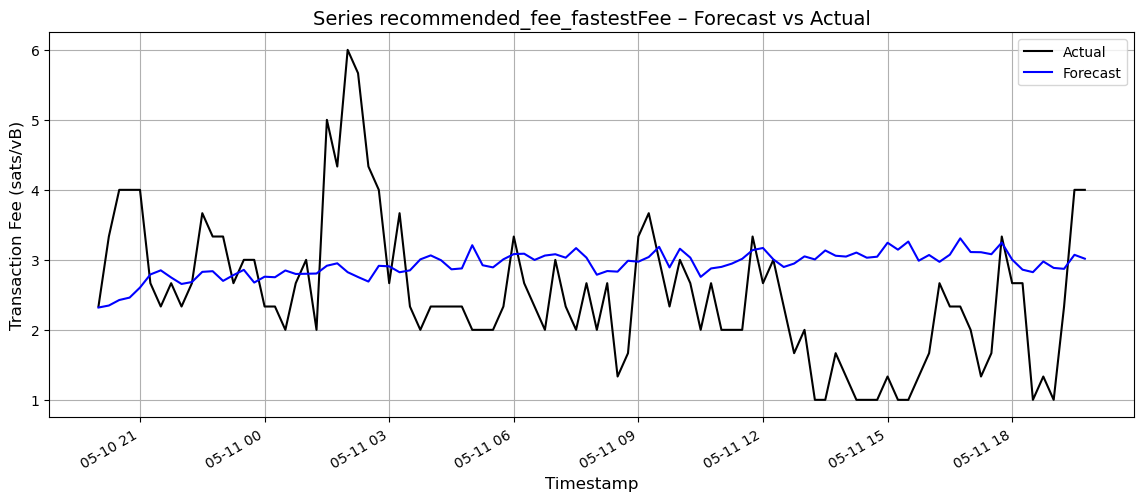

In [27]:
plot_series(df_eval, sid="recommended_fee_fastestFee")
plt.show()

We visualize DeepAR’s predictions on the `recommended_fee_fastestFee` series to assess temporal accuracy:

1. **Visual Comparison**: The black line represents actual transaction fees, while the blue line shows the DeepAR forecast.

2. **Spike Misses**: The model smooths over sharp spikes and drops in the actual values, failing to fully capture high-frequency volatility.

3. **Stability vs. Reactivity**: While the forecast is relatively stable, it underreacts to abrupt market shifts—indicating a conservative bias in prediction.

This underscores the importance of not relying solely on aggregate metrics, as visual inspection can reveal systematic patterns missed by numerical scores.


### Why This Step Is Crucial:
- Visual checks can reveal issues missed by aggregate metrics, such as lagging predictions, missed spikes, or unstable noise.  
- Ensures model predictions are interpretable and aligned with expected fee dynamics — essential for operational deployment in real-time Bitcoin fee estimation.

## 8. Conclusion: DeepAR for Bitcoin Fee Forecasting

In this notebook, we implemented a full DeepAR pipeline using PyTorch Forecasting to model and forecast Bitcoin transaction fees. The key steps included:

- **Preprocessing** and transforming multivariate time series data into a format compatible with sequence models.
- **Constructing TimeSeriesDataSet** objects with appropriate encoder/decoder lengths, covariates, and normalization.
- **Training the DeepAR model** with early stopping and learning rate tuning to ensure stable convergence.
- **Saving and loading** model checkpoints for reproducibility and deployment.
- **Evaluating performance** using MAE, RMSE, MAPE, and a custom MAE + STD + devErr penalty metric to account for both point accuracy and forecast variance.
- **Visualizing forecasts** to verify the model's ability to capture temporal dynamics and volatility in fee spikes.

### Key Takeaways:
- DeepAR is well-suited for forecasting Bitcoin fee series due to its ability to model **temporal dependencies**, **probabilistic uncertainty**, and **cross-series patterns**.
- Proper scaling, series separation (`series_id`), and window slicing (encoder/prediction) are critical to autoregressive models.
- Visualization and custom metrics help ensure that the model captures not just average behavior, but also the volatility that matters in fee-sensitive systems.

This modeling setup can now serve as a robust baseline for more advanced architectures like Transformer-based models (e.g., TFT) or external signal enrichment using price/mempool dynamics. Future improvements may include:
- Exploring adding weight to custom metric.
- Try to think of a better loss function. DeepAR requires a distribution loss.

